Примеры использования утилит из проекта umrr_utils

In [2]:
# импорты для примеров
import pandas as pd
import numpy as np
import os

In [3]:
# данные для примеров
df = pd.read_pickle('example_data/df_model.pkl')
# Создаем столбец с периодом. Буду считать поквартально.
df['date_quarter'] = df['date'].dt.to_period('Q')
df.sample(5, random_state=123)

,id,client_cat,client_ch,date,target_c,target_b,feat_num,feat_bin,feat_cat,sample,date_quarter
2648,2648,ГПБ,САЙТ,2021-01-21,43.072615,0,NaN,1,low,train,2021Q1
2456,2456,ГПБ,САЙТ,2020-12-24,546.093219,0,1070.543128,0,NaN,train,2020Q4
4557,4557,УЛИЦА,САЙТ,2021-10-27,218.535707,0,963.773574,0,high,train,2021Q4
4884,4884,УЛИЦА,САЙТ,2021-12-14,184.472895,0,-72.834623,0,low,train,2021Q4
92,92,ГПБ,САЙТ,2020-01-14,824.734947,1,1472.353553,1,medium,train,2020Q1


# Импорт библиотеки

In [3]:
# Указываем путь к папке где лежит папка 'umrr_utils'
import sys
folder_with_umrr_utils = '/work/dorovskikh/umrr_utils/' # пример пути!!
sys.path.append(folder_with_umrr_utils) 

assert 'umrr_utils' in os.listdir(folder_with_umrr_utils), "umrr_utils folder not found"

# SQL utils
Различные утилиты по работе с базами данных

In [5]:
from umrr_utils.sql import hadoop as hdp

## Коннект к хадуп
Класс для упрощения соединения с базами данных.

In [4]:
# примеры выгрузки данных из хадупа в pandas
# используйте те, которые вам удобны для ситуации
# используем конструкцию with, чтобы в случае ошибки в коде коннект безопасно закрывался

# инициализируем
db_conn = hdp.DB_Connector()

# Используя impala.dbapi.connect и pandas
# удобно работать с chunksize параметром (документация pandas read_sql)
with db_conn:
    df_1 = pd.read_sql('select * from sbx_001.rkk_useful_fields limit 5', con=db_conn.impala())

# Используем impala.dbapi.connect курсор (cursor)
# удобно когда не нужно выгружать данные, а например создать/удалить таблицу:
with db_conn:
    cursor = db_conn.imp_cursor()
    df_2 = cursor.execute('select * from sbx_001.rkk_useful_fields limit 5')
    
    script = """create table sbx_001.drv_tmp_001_utils as
                    select * from sbx_001.rkk_useful_fields limit 5"""
    cursor.execute(script)
    # удаляем таблицу
    cursor.execute('drop table if exists sbx_001.drv_tmp_001_utils purge')

# Используем ibis (ЕСЛИ УСТАНОВЛЕНА!)
# удобно, когда хотим обработать данные в хадуп питон кодом, но не выгружая их в питон
with db_conn:
    db_conn.ibis_conn_db('sbx_001') # в классе появляется новый атрибут db
    # что можно делать с объектом table - гуглим документацию python ibis
    table = db_conn.db.table('rkk_useful_fields') # из атрибута получаем таблицу
    df = table.execute(limit=10) # выгружаем в пандас 10 строк

## Загрузить таблицу в хадуп

In [ ]:
# Инициализируем коннект и загрузчик
db_conn = hdp.DB_Connector()
df_loader = hdp.DF_Loader()

# загружаем в хадуп
with db_conn:
    df_loader.load_df_to_hadoop(df, # таблица pandas
            tbl_name='drv_tmp_001_utils', # имя таблицы
            db_name='sbx_001', # дб
            db_conn=db_conn, # объект коннекта (hdp.DB_Connector())
            if_exists='raise', # что делать если таблица существует
            # 'raise' - выдать ошибку. 'drop' - удалить. 'append' - !попытаться! добавить данные
            add_new_cols_to_table=False, # экспериментально для append. не рекомендуется использовать
            table_schema=None, # схема таблицы
            hdfs_location=None, # папка c таблицей в файловой системе хадупа
                               )

# EDA utils
Функции для просмотра или анализа данных

## Найти коррелируемые

In [4]:
from umrr_utils.eda import find_corr_cols

In [5]:
# Для примера посчитаю, что таргет это тоже предиктор
all_features = ['feat_num', 'feat_bin', 'target_c', 'target_b']

# remove_order - опциональный параметр. 
# Если у вас есть список упорядоченный по убыванию важности предикторов
# То можно передать этот список и в 'remove_feat' запишется менее важный из пары
corr_cols = find_corr_cols(df[all_features], 
                           corr_thresh=0.5, # Фильтруем по этому параметру
                           method='pearson',
                           remove_order=all_features)

corr_cols

,col_1,col_2,corr,remove_feat
0,target_b,target_c,0.79373,target_b
1,feat_num,target_c,0.50006,target_c


## Графики

In [7]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

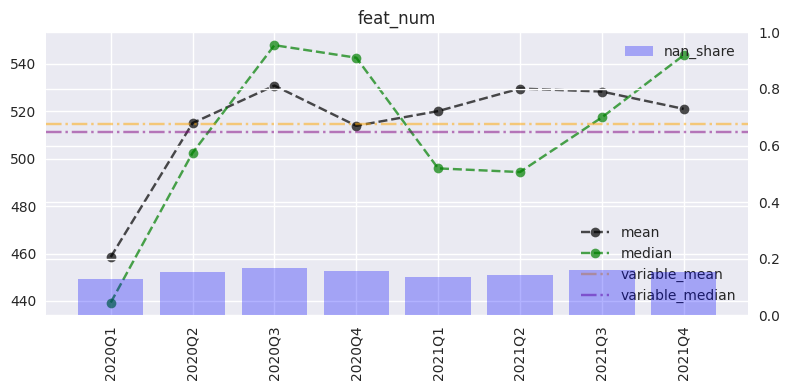

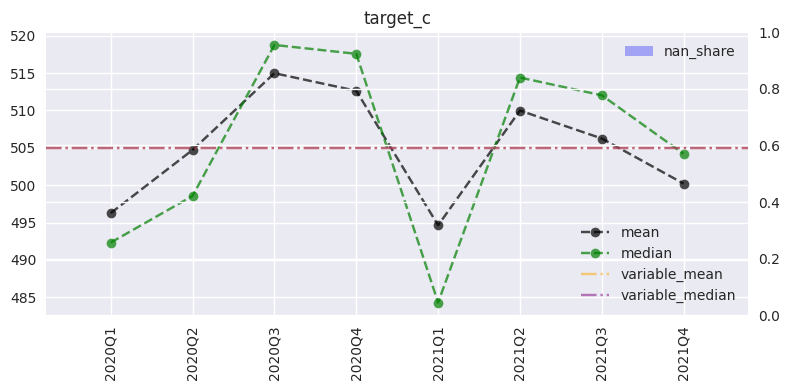

In [9]:
from umrr_utils.eda import nan_mean_median_plot

nan_mean_stats = nan_mean_median_plot(df, 
                 stat_cols=['feat_num', 'target_c'],
                 group_col='date_quarter',
                 # можно сохранить в PDF файл, правда тогда графики не покажет тут
                 #save_report_path='data/nan_mean.pdf',
                 figsize=(8, 4))

# Preprocessing

In [23]:
from umrr_utils.preproc.transf import LogPreprocessor
# LogPreprocessor - sklearn api лог трансофрмер




## уменьшить размер df (память)

In [ ]:
import umrr_utils.preproc.typing as type_utils

df = type_utils.reduce_mem_usage(df)

# type_utils.int_like_to_str - Целые в стринг

# Metrics utils
Функции для оценки качества моделей/прогнозов

## Посчитать метрики

Класс для быстрого расчета метрик и их сравнения.  
Удобство в том, что можно быстро проводить расчет на разных группах (сэмпл/сегмент и т.д.)    

Работает на прогнозах модели в pandas.DataFrame. То есть для оценки используются не модели, а только прогнозы.  
В текущем виде реализован только табличный вывод (графики возможно будут позже).

Продемонстрирую пример использования.  
Сделаю для модели с непрерывным таргетом (но принцип применения одинаковый, для любого типа векторного таргета).

In [4]:
from umrr_utils.metrics import MetricCalculator

Создадим исскуственные прогнозы.  
То есть на практике нам сперва нужно проскорить датафрейм моделью.  

In [5]:
# adding noise to target
df['pred_v1'] = df['target_c'] * (1 + np.random.normal(0, scale=0.2, size=len(df)))
df['pred_v2'] = df['target_c'] * (1 + np.random.normal(0, scale=0.1, size=len(df)))

df.sample(3)

,id,client_cat,client_ch,date,target_c,target_b,feat_num,feat_bin,feat_cat,sample,date_quarter,pred_v1,pred_v2
763,763,ГПБ,ДБО,2020-04-21,718.981796,1,-241.815043,0,high,train,2020Q2,722.824085,742.034368
3721,3721,КРК,ДБО,2021-06-27,987.523505,1,416.303277,0,high,train,2021Q2,931.787827,961.411790
3395,3395,КРК,САЙТ,2021-05-10,943.954791,1,2081.254487,1,NaN,test,2021Q2,947.093847,892.536203


Инициализируем калькулятор метрик.  
Ему нужно передать, какие метрики мы хотим замерять.  
Можно свои, можно другие. 

In [7]:
# Определяем метрики, количество может быть любое, для примера только 2 метрики
from sklearn.metrics import r2_score

# Когда создаем свои метрики, следуем принципам sklearn - первые 2 аргумента всегда y_true, y_pred
def custom_max_error(y_true, y_pred, coeff=1):
    return np.max(np.abs(y_true - y_pred * coeff)) 
    
# Записываем функции расчета метрик в словарь, чтобы дать им имена
metr_funcs = {'r2': r2_score,
              'my_max_error': custom_max_error}

# можно считать отдельно статы. Также можно писать кастомные функции 2х аргументов
# Отличие от метрик что в функцию надо вместо вместо прогноза передавать весь df
# и статы считаются один раз для группы (а не для каждого прогноза), что эффективней
stats_funcs = {'n_obs': lambda y_true, df: len(df),
                'mean_targ': lambda y_true, df: np.mean(y_true),
              'targ_sum': lambda y_true, df: np.sum(y_true)}

Возможно считать метрики с доверительными интервалами используя сэмплирование бутстрапом

In [7]:
# создаем калькулятор
metr_calc_boots = MetricCalculator(metr_funcs,
                             stats_funcs  ,    
                             calc_ci_bootstrap=True, # Использовать ли бутстрап при расчете
                             bootstrap_iters=100, # количество итераций
                             confidence_interval=90, # уровень доверия
                            )

# Можно калькулятору передавать параметры расчета метрик и статов. Например coeff в custom_max_error. 
metr_calc_boots.funcs_params = {'my_max_error': dict(coeff=1)}

Запускаем расчет метрик. Как видно в конце добавились столбцы со статистиками, которые считались отдельно от бутстрапа

In [8]:
metr_boots = metr_calc_boots.calculate(df, # датафрейм с таргетом и прогнозами
                             true_col='target_c', # столбец с таргетом
                             pred_cols='pred_v1', # прогноз
                             group_cols=['sample'], # Группы на которых считаем метрики отдельно
                             # Какие группы исключать из группировки (комбинации всех исключений),
                             # т.е. взятие группы целиком ('all') для расчета метрики
                             groupby_exclude_combinations=None, # по умолчанию None
                             )

# Если group_cols=None, мы бы получили только строку all. Иначе получаем метрики групп.
# n_obs - количество наблюдений в группе.
metr_boots

,pred,sample,r2,r2_conf_5,r2_conf_95,my_max_error,my_max_error_conf_5,my_max_error_conf_95,n_obs,mean_targ
0,pred_v1,test,0.832625,0.817277,0.848144,614.143412,493.344700,614.143412,1500.0,513.487449
1,pred_v1,train,0.836919,0.824500,0.845013,747.303152,585.013639,747.303152,3500.0,501.362522


Для roc_auc имплементирован расчет ДИ, через нормальное распределение.  
Если требуется джини, то результат расчета нужно будет преобразовать - roc_auc * 2 - 1

In [15]:
from sklearn.metrics import roc_auc_score
metr_funcs_auc = {'roc_auc': roc_auc_score}
# создаем калькулятор
metr_calc_norm = MetricCalculator(metr_funcs_auc,
                             stats_funcs,    
                             # добавить ДИ для метрики используя нормальное распределение 
                             calc_ci_normal=True, 
                             calc_ci_metrics=['roc_auc'], # на какие конкретно метрики считаем ДИ
                             confidence_interval=90, # уровень доверия
                            )

metr_norm = metr_calc_norm.calculate(df, # датафрейм с таргетом и прогнозами
                             true_col='target_b', # столбец с таргетом
                             pred_cols='pred_v1', # прогноз
                             group_cols=['sample'], # Группы на которых считаем метрики отдельно
                             )

metr_norm

,pred,sample,roc_auc,roc_auc_conf_5,roc_auc_conf_95,n_obs,mean_targ,targ_count
0,pred_v1,test,0.952614,0.944298,0.960929,1500.0,0.3,450.0
1,pred_v1,train,0.959816,0.954844,0.964788,3500.0,0.3,1050.0


Можно передать сразу несколько прогнозов разных моделей, для их быстрого сравнения.  
И также можно передать сразу несколько групп.

In [9]:
metr_calc = MetricCalculator(metr_funcs, stats_funcs) # переинициализирую без бутстрапа

group_cols = ['sample', 'client_ch']
# Передаем сразу 2 прогноза
metr_gr = metr_calc.calculate(df,
                             true_col='target_c', # столбец с таргетом
                             pred_cols=['pred_v1', 'pred_v2'], # прогнозы
                             group_cols=group_cols, # Группы на которых считаем метрики отдельно
                             #pivot_metr='r2' # для удобного сравнения моделей только по r2
                             # Какие группы исключать из группировки (комбинации всех исключений),
                             # т.е. взятие группы целиком ('all') для расчета метрики
                             groupby_exclude_combinations=group_cols, # по умолчанию None
                             )

# пример как преобразовать метрики, чтобы разные модели были как столбцы
# metr_piv = pd.pivot_table(metr_gr,
#             values='r2', # нужная метрика
#             index=group_cols,
#             columns='pred')
# metr_piv.columns.name = None
# metr_piv = metr_piv.reset_index()

metr_gr.sort_values(['pred', 'sample', 'client_ch'])

,pred,sample,client_ch,r2,my_max_error,n_obs,mean_targ
4,pred_v1,all,all,0.833360,687.571864,5000.0,505.000000
5,pred_v1,all,ДБО,0.823438,687.571864,2509.0,505.933012
6,pred_v1,all,САЙТ,0.843714,506.797537,2491.0,504.060246
7,pred_v1,test,all,0.834462,687.571864,1500.0,513.487449
0,pred_v1,test,ДБО,0.810058,687.571864,738.0,517.696808
1,pred_v1,test,САЙТ,0.857334,418.839694,762.0,509.410670
8,pred_v1,train,all,0.832810,600.778337,3500.0,501.362522
2,pred_v1,train,ДБО,0.828456,600.778337,1771.0,501.030877
3,pred_v1,train,САЙТ,0.837555,506.797537,1729.0,501.702222
13,pred_v2,all,all,0.958345,309.135564,5000.0,505.000000


In [10]:
# обращаемся с метриками как с обычным pandas df
# Допустим меня интересует только ТЕСТ и ДБО
metr_gr[(metr_gr['sample'] == 'test') & (metr_gr['client_ch'] == 'ДБО')]

,pred,sample,client_ch,r2,my_max_error,n_obs,mean_targ
0,pred_v1,test,ДБО,0.810058,687.571864,738.0,517.696808
9,pred_v2,test,ДБО,0.951094,256.847799,738.0,517.696808


In [11]:
# для сравнения прогнозов по одной метрике
metr_calc.simple_predict_pivot(metr_gr,
                              metric='r2', 
                               # be carefull selecting not all groups. Takes first value
                               group_cols=group_cols)['test']

client_ch,all,ДБО,САЙТ
pred_v1,0.834462,0.810058,0.857334
pred_v2,0.954753,0.951094,0.958174


## метрики по периодам (кварталам, месяцам..)
Или другим группам...  
В данном примере мы в group_cols добавили все группы, а в groupby_exclude_combinations не включили кварталы. Т.е. у нас не будет расчета метрики по всему периоду, а только по кварталам, но будет расчет по всем сэмплам, каналам, категориям в различных комбинациях. Получится длинный датафрейм с расчетам различных комбинаций подвыборок.

In [12]:
metr_calc = MetricCalculator(metr_funcs, stats_funcs) # переинициализирую без бутстрапа

# Передаем сразу 2 прогноза. Но можно один
metr_gr = metr_calc.calculate(df,
                             true_col='target_c', # столбец с таргетом
                             pred_cols=['pred_v1', 'pred_v2'], # прогнозы
                             group_cols=['date_quarter', 'sample', 'client_ch', 'client_cat'], # Группы на которых считаем метрики отдельно
                             #pivot_metr='r2', # для удобного сравнения моделей только по одной метрике
                              # Какие группы исключать из группировки (комбинации всех исключений),
                             # т.е. взятие группы целиком ('all') для расчета метрики
                             groupby_exclude_combinations=['sample', 'client_ch', 'client_cat'], # по умолчанию None
                             )
print(metr_gr.shape)
metr_gr.head(3)

(578, 9)


,pred,date_quarter,sample,client_ch,client_cat,r2,my_max_error,n_obs,mean_targ
0,pred_v1,2020Q1,test,ДБО,ГПБ,0.822158,355.048823,24.0,525.035007
1,pred_v1,2020Q1,test,ДБО,КРК,0.839226,345.444068,30.0,459.681936
2,pred_v1,2020Q1,test,ДБО,УЛИЦА,0.929873,210.624330,28.0,428.768897


## Стабильность (PSI/CSI)

Расчитываем PSI и CSI переменных.  
* PSI
Cравниваем распределение по квантилям. (Не улавливает изменения в среднем значении выборки)   

* CSI
Cравниваем распределение по бинам (более точная и строгая метрика).
Бины получаем разбив первый период по квантилям.  


* Категориальные  
Для переменных категориальных (или меньше уникальных значений чем n_bins) считается CSI.  
Каждое значение пишется в свою группу и сравниваются их распределения по периодам.  
Ранее не встретившиеся значения пишутся в "другую" группу, которая имеет 0 наблюдений в сравниваемом пероиде.  

In [13]:
from umrr_utils.metrics import StabilityIndexCalculator

In [14]:
# Инициализируем калькулятор
psi_calc = StabilityIndexCalculator()

# Берем список переменных на которых хотим посчитать стабильность.
calc_psi_cols = ['feat_num', 'feat_bin', 'feat_cat', 'target_c']

In [6]:
# Запускаем расчет
psi_res_all, psi_bin_counts = psi_calc.calculate(df, # данные
                  var_names=calc_psi_cols, # какие столбцы считаем
                  group_col='date_quarter', # столбец определяющий периоды
                  # initial_val='2020Q2', # с каким периодом сравниваем остальные, по умолчанию первый
                  n_bins=5, # Количество квантилей|бинов
                  exclude_miss=False, # исключилть ли пустые значения из расчета стабильности
                  exclude_out_int=False, # Исключить сильные аутлаеры
                  bin_edge_std=1, # Расширяем мин/макс бины на N std бинов.
                  return_bin_counts=True, # возвращаем дополнительное инфо по бинам
                  # При желании задаем кастомные границы/количества бинов для каждой переменной. 
                  # variable_bins={'feat_num': [-np.inf, 10, 100, np.inf]},
                  # variable_n_bins={'feat_bin': 10}
                  ) 

In [13]:
group_col = 'date_quarter'
(df[group_col].value_counts()
                              .sort_index().reset_index()
                                .rename(columns={'index': group_col, group_col: 'counts'})
                               )

,date_quarter,counts
0,2020Q1,624
1,2020Q2,623
2,2020Q3,630
3,2020Q4,630
4,2021Q1,616
5,2021Q2,623
6,2021Q3,630
7,2021Q4,624


WARNING [INFO] Changed n_bins   
Это корректное поведение. Расчет уведомляет вас, что во время квантилизации не удалось разбить переменную на заданное количество бинов (например недостаточно уникальных значений).

Результат это словарик со статистикой по периодам для каждой переменной.

In [15]:
# Например для переменной feat_num
psi_res_all['feat_num']

,n_obs,n_nans,hitrate,psi
date_quarter,,,,
2020Q1,624,80,0.871795,0.000000
2020Q2,623,96,0.845907,0.009673
2020Q3,630,105,0.833333,0.024748
2020Q4,630,98,0.844444,0.013874
2021Q1,616,84,0.863636,0.011418
2021Q2,623,90,0.855538,0.013725
2021Q3,630,101,0.839683,0.014689
2021Q4,624,96,0.846154,0.011484


In [16]:
# по бинам
psi_bin_counts['feat_num']

,fit,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4
"(-inf, 10.0]",0.195513,0.195513,0.171750,0.157143,0.157143,0.167208,0.152488,0.160317,0.163462
"(10.0, 100.0]",0.035256,0.035256,0.043339,0.022222,0.034921,0.051948,0.035313,0.039683,0.041667
"(100.0, inf]",0.641026,0.641026,0.630819,0.653968,0.652381,0.644481,0.667737,0.639683,0.641026
_missing,0.128205,0.128205,0.154093,0.166667,0.155556,0.136364,0.144462,0.160317,0.153846
_out_of_interval,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Результат можно перевести в широкую таблицу по периодам

In [17]:
psi_calc.make_wide_table(psi_res_all)

date_quarter,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4
feat_num,0.0,0.009673,0.024748,0.013874,0.011418,0.013725,0.014689,0.011484
feat_bin,0.0,0.000312,0.000091,0.002918,0.000852,0.001136,0.000364,0.000257
feat_cat,0.0,0.011761,0.000841,0.005143,0.002394,0.003078,0.012227,0.005313
target_c,0.0,0.003865,0.007433,0.009034,0.010752,0.005624,0.003766,0.004434


После метода calculate можно получить таблицу с распределениями по бинам по каждой переменной

In [19]:
# в данном случае fit равен 2020Q1
psi_calc.beautify_bin_distr_table(psi_bin_counts)

fit    2020Q1    2020Q2    2020Q3    2020Q4  \
variable bins                                                                 
feat_num -inf: 10.0        0.195513  0.195513  0.171750  0.157143  0.157143   
         10.0: 100         0.035256  0.035256  0.043339  0.022222  0.034921   
         100: inf          0.641026  0.641026  0.630819  0.653968  0.652381   
         _missing          0.128205  0.128205  0.154093  0.166667  0.155556   
         _out_of_interval  0.000000  0.000000  0.000000  0.000000  0.000000   
feat_bin -0.68: 0.0        0.501603  0.501603  0.510433  0.496825  0.474603   
         0.0: 1.69         0.498397  0.498397  0.489567  0.503175  0.525397   
         _missing          0.000000  0.000000  0.000000  0.000000  0.000000   
         _out_of_interval  0.000000  0.000000  0.000000  0.000000  0.000000   
feat_cat low               0.272436  0.272436  0.256822  0.276190  0.300000   
         high              0.291667  0.291667  0.260032  0.301587  0.285714   
         medium            0.283654  0.283654  0.330658  0.276190  0.258730   
         _missing          0.152244  0.152244  0.152488  0.146032  0.155556   
         _out_of_interval  0.000000  0.000000  0.000000  0.000000  0.000000   
target_c -326: 207         0.198718  0.198718  0.186196  0.196825  0.195238   
         207: 388          0.200321  0.200321  0.195827  0.180952  0.168254   
         388: 596          0.200321  0.200321  0.224719  0.196825  0.225397   
         596: 793          0.200321  0.200321  0.195827  0.192063  0.209524   
         793: 1429         0.200321  0.200321  0.197432  0.233333  0.201587   
         _missing          0.000000  0.000000  0.000000  0.000000  0.000000   
         _out_of_interval  0.000000  0.000000  0.000000  0.000000  0.000000   

                             2021Q1    2021Q2    2021Q3    2021Q4  
variable bins                                                      
feat_num -inf: 10.0        0.167208  0.152488  0.160317  0.163462  
         10.0: 100         0.051948  0.035313  0.039683  0.041667  
         100: inf          0.644481  0.667737  0.639683  0.641026  
         _missing          0.136364  0.144462  0.160317  0.153846  
         _out_of_interval  0.000000  0.000000  0.000000  0.000000  
feat_bin -0.68: 0.0        0.487013  0.484751  0.492063  0.493590  
         0.0: 1.69         0.512987  0.515249  0.507937  0.506410  
         _missing          0.000000  0.000000  0.000000  0.000000  
         _out_of_interval  0.000000  0.000000  0.000000  0.000000  
feat_cat low               0.269481  0.288925  0.314286  0.299679  
         high              0.300325  0.284109  0.250794  0.266026  
         medium            0.293831  0.264848  0.285714  0.288462  
         _missing          0.136364  0.162119  0.149206  0.145833  
         _out_of_interval  0.000000  0.000000  0.000000  0.000000  
target_c -326: 207         0.219156  0.200642  0.187302  0.213141  
         207: 388          0.168831  0.173355  0.195238  0.179487  
         388: 596          0.220779  0.211878  0.192063  0.201923  
         596: 793          0.185065  0.199037  0.223810  0.192308  
         793: 1429         0.206169  0.215088  0.201587  0.213141  
         _missing          0.000000  0.000000  0.000000  0.000000  
         _out_of_interval  0.000000  0.000000  0.000000  0.000000

Для каждой переменной можно получить небольшой свод

In [20]:
psi_calc.make_stat_summary_table(psi_res_all) # передаем результат расчета

,feat_num,feat_bin,feat_cat,target_c
psi_min,0.009673,0.000091,0.000841,0.003766
psi_max,0.024748,0.002918,0.012227,0.010752
psi_mean,0.014230,0.000847,0.005822,0.006415
hitrate_min,0.833333,1.000000,0.837881,1.000000
hitrate_max,0.863636,1.000000,0.863636,1.000000
hitrate_mean,0.846956,1.000000,0.850343,1.000000


Или можно визаулизировать расчет  
Также его можно сохранить в PDF (тогда не выведет в юпитер)

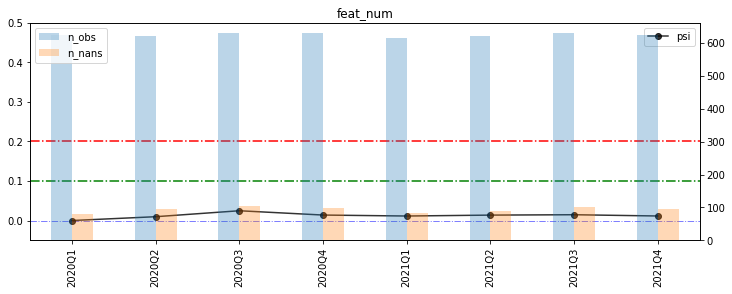

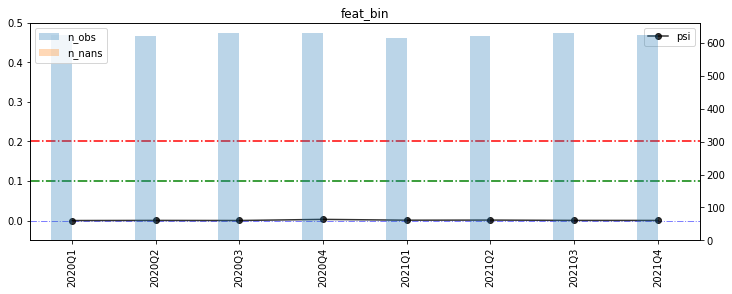

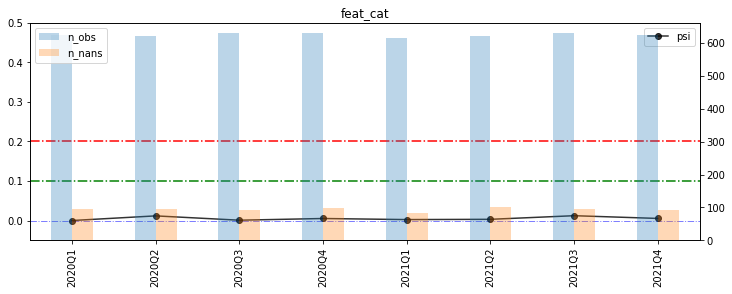

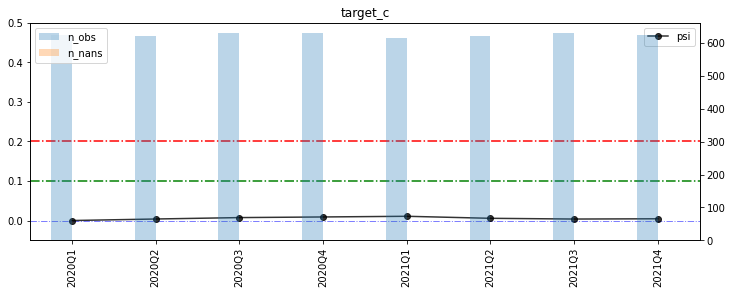

In [21]:
# psi_calc.plot_calculations(psi_res_all, figsize=(12, 4), save_report_path='data/psi_graphs.pdf')
psi_calc.plot_calculations(psi_res_all, figsize=(12, 4))

Сохраняем в эксель

In [ ]:
psi_calc.calculation_to_excel(psi_res_all, 
                              psi_bin_counts,
                              filepath='dev_data/psi_test.xlsx', 
                              # можно убрать какие то переменные
                              drop_vars=['feat_num'],
                              # параметр для отображения бинов. лучше оставить 3 по умолчанию
                              bin_symbols=3
                             )

### доп. функционал psi

Тут хранятся границы бинов полученные калькулятором во время "фиттинга"

In [22]:
psi_calc.fit_data['bins_dict']

{'feat_num': [-inf, 10, 100, inf],
 'feat_bin': array([-0.68186769,  0.        ,  1.69070194]),
 'feat_cat': array(['low', 'high', 'medium', nan], dtype=object),
 'target_c': array([-326.10861763,  207.4454891 ,  388.45369074,  595.60312062,
         793.44468894, 1428.68356525])}

Тут хранятся данные по бинам для каждой переменной. Если заново выполнить fit, данные конкретной переменной перезапишутся.

In [23]:
psi_calc.calc_bins_counts['feat_num']

,fit,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4
"(-inf, 10.0]",0.195513,0.195513,0.171750,0.157143,0.157143,0.167208,0.152488,0.160317,0.163462
"(10.0, 100.0]",0.035256,0.035256,0.043339,0.022222,0.034921,0.051948,0.035313,0.039683,0.041667
"(100.0, inf]",0.641026,0.641026,0.630819,0.653968,0.652381,0.644481,0.667737,0.639683,0.641026
_missing,0.128205,0.128205,0.154093,0.166667,0.155556,0.136364,0.144462,0.160317,0.153846
_out_of_interval,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


У класса сделаны fit/predict методы, для более детальных экспериментов.

Например посмотреть более детально таблицу распределения по бинам можно так:

In [24]:
var = 'feat_num'
# Сравниваем 2020 первый квартал со вторым, ставлю 5 бинов
psi_calc.fit(df.loc[df['date_quarter'] == '2020Q1', var], n_bins=5, bins=[-np.inf, 10, 100, np.inf])

# PSI
psi, psi_tab = psi_calc.predict(df.loc[df['date_quarter'] == '2020Q2', var], 
                                    return_table=True) # return psi_tab

# То есть var_exp - наблюдения в 1 квартале, var_obs - во втором.
print(f"PSI={round(psi, 5)}")
display(psi_tab)

PSI=0.00967


,var_exp,var_obs,psi,bins_obs
"(-inf, 10.0]",0.195513,0.171750,0.003079,"(-inf, 10.0]"
"(10.0, 100.0]",0.035256,0.043339,0.001668,"(10.0, 100.0]"
"(100.0, inf]",0.641026,0.630819,0.000164,"(100.0, inf]"
_missing,0.128205,0.154093,0.004761,_missing
_out_of_interval,0.000000,0.000000,0.000000,_out_of_interval


In [25]:
# shortcut for single fit
psi_tabs = psi_calc.get_psi_table(df, var='feat_num', 
                      group_var='date_quarter', 
                      fit_group='2020Q1', 
                      pred_group='2020Q4',
                      n_bins=5,
                  exclude_miss=False, exclude_out_int=False, bin_edge_std=1)
psi_tabs

,var_exp,var_obs,psi,bins_obs
"(-2396.035, -74.674]",0.173077,0.126984,0.014274,"(-2396.035, -74.674]"
"(-74.674, 326.569]",0.174679,0.168254,0.000241,"(-74.674, 326.569]"
"(326.569, 605.907]",0.174679,0.177778,0.000054,"(326.569, 605.907]"
"(605.907, 948.329]",0.174679,0.203175,0.004306,"(605.907, 948.329]"
"(948.329, 3918.207]",0.174679,0.168254,0.000241,"(948.329, 3918.207]"
_missing,0.128205,0.155556,0.005289,_missing
_out_of_interval,0.000000,0.000000,0.000000,_out_of_interval


In [26]:
# сохранить фит
# psi_calc.save_fit('example_data/psi_fitdata.pkl')

# загрузить фит
psi_calc_loaded = StabilityIndexCalculator()
psi_calc_loaded.load_fit('example_data/psi_fitdata.pkl')

# распределения во время fit
psi_calc_loaded.fit_data['feat_num']['var_cnt_exp'].to_frame()

,feat_num
"(-inf, 10.0]",0.195513
"(10.0, 100.0]",0.035256
"(100.0, inf]",0.641026
_missing,0.128205
_out_of_interval,0.000000


### распределение по таргету
Также доп функционал PSI  
Смотрим стабильность распределения таргета в бинах переменной. То есть, что "логика" предсказаний предиктора значимо не меняется во времени.
Расчет аналогичен PSI, но считаем не доли наблюдений в персентилях, а средний таргет. То есть как распределен средний таргет в бинах(персентилях) переменной. Для расчета итогового значения в отличие от PSI нормируем не на себя (наблюдаемый период), а всегда нормируем на ожидаемый период, тем самым обнаруживая смещения в среднем таргете по периодам (параллельные сдвиги).
В некотором роде это комбинация PSI и Information Value.

In [20]:
# просто берем обычный расчет, но даем ей параметр с целевой переменной - distrib_targ
# использует теже параметры, что и расчет psi

targ_res_all, targ_bin_all = psi_calc.calculate(df, # данные
                  var_names=['feat_num', 'feat_bin', 'feat_cat'], # какие столбцы считаем
                  group_col='date_quarter', # столбец определяющий периоды
                  n_bins=5, # Количество квантилей|бинов
                  exclude_miss=False, # исключилть ли пустые значения из расчета стабильности
                  exclude_out_int=False, # Исключить сильные аутлаеры
                  bin_edge_std=1, # Расширяем мин/макс бины на N std бинов.
                  return_bin_counts=True, # возвращаем дополнительное инфо по бинам
                  distrib_targ='target_c'
                  ) 

In [21]:
# это средний таргет в бине, который затем нормируется по сумме 'fit' и считается по формуле PSI
targ_bin_all['feat_num']

,fit,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4
feat_num,,,,,,,,,
"(-2396.035, -74.674]",272.446489,272.446489,315.784036,223.607579,268.664483,283.094419,262.050897,297.463265,287.012077
"(-74.674, 326.569]",427.543802,427.543802,397.818397,461.431286,441.612379,402.502448,397.554902,389.051315,421.464418
"(326.569, 605.907]",481.323366,481.323366,497.027002,482.930834,490.615605,489.303298,508.279921,482.585132,479.110915
"(605.907, 948.329]",592.183758,592.183758,579.129459,587.471546,608.806793,528.209697,570.278570,638.424395,555.018204
"(948.329, 3918.207]",710.400686,710.400686,679.592347,698.195688,673.716668,714.483700,708.424399,701.262709,690.119413
_missing,489.998500,489.998500,506.928823,520.687566,513.901678,490.684565,511.506701,461.159717,478.668984
_out_of_interval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
targ_res_all['feat_num']

,n_obs,n_nans,hitrate,psi
date_quarter,,,,
2020Q1,624,80,0.871795,0.000000
2020Q2,623,96,0.845907,0.003792
2020Q3,630,105,0.833333,0.004826
2020Q4,630,98,0.844444,0.001422
2021Q1,616,84,0.863636,0.003157
2021Q2,623,90,0.855538,0.001953
2021Q3,630,101,0.839683,0.003758
2021Q4,624,96,0.846154,0.001384


## Прочие метрики и статистики

In [27]:
from umrr_utils.metrics import metrics as umrr_metr

### VIF

In [28]:
umrr_metr.calculate_vifs(df[['feat_num', 'feat_bin']])

feat_num    1.024107
feat_bin    1.024107
Name: VIF, dtype: float64

### IV
Используем ContinuousOptimalBinning

In [29]:
umrr_metr.iv_score(y_true=df['target_c'], 
         y_pred=df['feat_cat'])

56.249427485497094

### Хит непрерывной целевой
Матрица попаданий прогноза и таблица попаданий в окно

Сначала забиним целевую и прогноз

#### Биним по квантилям округляя границы бинов

In [30]:
from umrr_utils.binning import round_binning

# Биним по квантилям округляя границы бинов
target_bin, bins, bin_labels = round_binning(df['target_c'], # что биним
                           q=10, # квантили
                           round_val=10, # размер округления бинов
                           bin_labels_scale=1, # если надо преобразовать лабелы
                           retbins=True, 
                           bin_edges=[-1000, 3000], # мин/макс бин
                           decimals=0)

pred_bin = pd.cut(df['pred_v1'], bins=bins, labels=bin_labels)

target_bin.value_counts(sort=False)

-1000-110    505
110-210      505
210-310      505
310-410      505
410-500      455
500-600      505
600-700      505
700-800      505
800-900      505
900-3000     505
Name: target_c, dtype: int64

Посмотрим матрицу. По сути это обычная confusion matrix.  
Столбцы отражают прогнозное значение, строки - таргет.  
И диагональ это точные прогнозы (попавшие в окно).

In [31]:
umrr_metr.bin_accuracy_table(target_bin=target_bin, 
                        pred_bin=pred_bin, 
                        bin_labels=bin_labels)

,-1000-110,110-210,210-310,310-410,410-500,500-600,600-700,700-800,800-900,900-3000
-1000-110,470,35,0,0,0,0,0,0,0,0
110-210,51,386,67,1,0,0,0,0,0,0
210-310,1,98,301,97,8,0,0,0,0,0
310-410,0,10,115,240,118,22,0,0,0,0
410-500,0,1,28,132,146,117,28,2,1,0
500-600,0,2,8,40,113,188,108,38,8,0
600-700,0,0,5,11,48,119,139,123,46,14
700-800,0,0,1,8,14,57,90,134,109,92
800-900,0,0,0,4,10,27,58,87,117,202
900-3000,0,0,0,2,1,9,29,60,101,303


#### Таблица попадания в окно.  
Таблица показывает долю прогнозов в групе целевой, попавшей в окно и больше/меньше окна.  

In [32]:
# Опять сперва делим целевую на группы. Я делаю это путем бининга.
bins = np.arange(0, 11) * df['target_c'].max() / 10
target_bin_2 = pd.cut(df['target_c'], bins=bins,
                     labels=bins[1:].astype(int))

umrr_metr.continuous_hit_table(df, 
                     target_group=target_bin_2,
                     window=10, # Окно, либо значение целевой либо процент.
                     target_name='target_c',
                     pred_name='pred_v1',
                     percent=False, # Попадание в окно или в % от целевой
                     w_label=None,
                     )

,total,Hit in 10,Higher then 10,Lower then 10
target_c,,,,
10 - 100,455,0.674725,0.156044,0.169231
100 - 200,505,0.259406,0.419802,0.320792
200 - 300,505,0.166337,0.413861,0.419802
300 - 400,505,0.104950,0.471287,0.423762
400 - 500,505,0.089109,0.447525,0.463366
500 - 600,505,0.112871,0.437624,0.449505
600 - 700,505,0.051485,0.477228,0.471287
700 - 800,505,0.047525,0.497030,0.455446
800 - 900,505,0.055446,0.497030,0.447525


Как видно, с ростом значений попадание в окно "10" начинает резко падать, поэтому можно сделать окно в %.  
То есть попадание в % от целевой.

И Можно вызвать доп. функцию, которая итерируется по прогнозам, объединяя их в сравнительную таблицу

In [33]:
umrr_metr.compare_continuous_hits(df, 
                     target_group=target_bin_2,
                     window=10,
                     target_name='target_c',
                     pred_names=['pred_v1', 'pred_v2'],
                     pred_labels=['v1', 'v2'],
                     percent=True)

,total,Hit in 10% v1,Higher then 10% v1,Lower then 10% v1,Hit in 10% v2,Higher then 10% v2,Lower then 10% v2
target_c,,,,,,,
10 - 100,455,0.386813,0.309890,0.303297,0.672527,0.173626,0.153846
100 - 200,505,0.390099,0.338614,0.271287,0.720792,0.144554,0.134653
200 - 300,505,0.400000,0.291089,0.308911,0.685149,0.154455,0.160396
300 - 400,505,0.376238,0.334653,0.289109,0.710891,0.158416,0.130693
400 - 500,505,0.332673,0.326733,0.340594,0.722772,0.120792,0.156436
500 - 600,505,0.400000,0.297030,0.302970,0.675248,0.156436,0.168317
600 - 700,505,0.362376,0.312871,0.324752,0.681188,0.152475,0.166337
700 - 800,505,0.400000,0.336634,0.263366,0.659406,0.160396,0.180198
800 - 900,505,0.354455,0.334653,0.310891,0.673267,0.178218,0.148515


# Feature selection

## Обучаемся на разных предикторах
Класс для итерации по наборам предикторов, обучении на них модели и сохранении метрик. На основе этих метрик можно будет выбрать подходящий набор.

Основной функционал:
* Просто передать словарь с наборами вида {'feauters_v1': ['feat', .., 'feat_n'], 'feauters_v2': [...] ...}
* Передать список предикторов и рекурсивно добавлять/убирать по предиктору
* Перебрать все комбинациии (можно задать базовый набор к которому добавляются комбинации)
* RFE с важностью фичей. Рекурсивно обучаем модель и убираем "маловажные" предикторы.
* Убирать/добавлять каждый предиктор (один) из набора.

Данному классу для работы нужно передать функции:

* Обучения и прогноза на данных
* Получения метрик
* (опционально) Получения некоего feature_importance (из модели или shap) (для RFE метода)  

Далее я создам простейшую модель и задам необходимые функции

In [4]:
from umrr_utils.feat_select import Feature_Iterator

In [5]:
# Для примера использую простейшую модель возвращающую средний таргет с шумом.

class some_model:
    def fit(self, x, y):
        self.feat_imp = np.random.rand(x.shape[1])
        self.target_mean = np.mean(y)
    
    def predict(self, x):
        preds = self.target_mean * (1 + np.random.normal(0, scale=0.2, size=len(x)))
        return preds

In [22]:
# Функция обучения. Может использовать глобальные переменные. Например train_mask
train_mask = df['sample'] == 'train'
metr_calc = MetricCalculator(metr_funcs, stats_funcs)


def train_pred_func(df, features, target_col):
    model = some_model()
    # Тренирововчные данные или кросс-вал-предикт
    model.fit(df.loc[train_mask, features], df[target_col])
    
    # Можно давать прогноз на всех данных, а отделить треин тест в скоринговой функции
    preds = model.predict(df[features])
    return preds, model
    
# Здесь для скоринга я использую объект класса MetricCalculator, который мы инициализировали выше
def score_func(df, true_col, pred_col='_preds_tmp'):
    
    df_metr = metr_calc.calculate(df, 
                     true_col=true_col, 
                     pred_cols=pred_col, 
                     group_cols=['sample'])
        
    
    return df_metr.drop(columns=['pred'])

# Если последовательно исключаем предикторы используя некий importance, то нужна функция
# Для получения этих feature_importance и оборачивания их в требуемый формат pandas 
def feat_imp_func(data, model, feats):
    df_fi = pd.DataFrame({'col_name': feats, 'fi': model.feat_imp})
    return df_fi

In [31]:
# Инициализируем класс, передав ему функции
feat_iterator = Feature_Iterator(train_pred_func, 
                               score_func,
                               feat_imp_func)

df['feat_pair_0'] = df['feat_num'] * df['feat_bin']
df['feat_pair_1'] = df['feat_num'] * (1 - df['feat_bin'])

# предикторы с которыми я собираюсь работать
iterate_feat = ['feat_num', 'feat_bin', 'feat_cat', ['feat_pair_0', 'feat_pair_1']]
# доп функционал, что набор предикторов может содержать группу, которая будет считаться 
# как один шаг итерации отбора в любом из режимов, то есть эти предикторы никогда не будут разделены
# это полезно когда вы хотите использовать какой то предиктор только в паре/группе, 
# например набор фичей отражающих вероятность принадлежности к бину
                

Запустим в режиме recursive feature elimination на основе feature importance

In [32]:
df_metr_it, _train_feats = feat_iterator.iterate(df, # данные
                            features=iterate_feat, # предикторы (порядок важен)
                            target_col='target_c', # целевая
                            # мин количество предикторов 
                            # Для исключения определяет когда остановиться, для добавления с какого начать
                            min_feat=1, 
                            # single - поочередно добавлять/убирать один предиктор.
                            method='recursive', # ('combinations', 'single', 'recursive')
                            process='eliminate', # ('eliminate', 'add')
                            # убирать по заданному порядку предикторов или замерять feature importance
                            rec_elim_order='feat_imp', # ('static', 'feat_imp')
                            rfe_step=1, # шаг, для recursive elimination
                            save_models=False, # сохраняются в атрибут models_dict по feat_label
                            # можно передать доп. параметры функциям треина/скоринга
                            train_params={}, 
                            score_params={},
                            base_feats=[], # базовый набор для комбинаций
                            verbose=True # выводить доп инфу о процессе
                            )

# В столбце feat_label указан только последний убранный предиктор или прочее имя расчета
# из _train_feats переменной я могу взять полные списки предикторов, на которых учились модели.
df_metr_it['all_train_feats'] = df_metr_it['feat_label'].map(_train_feats)

# показываю только тестовые метрики (какие метрики я сохраняю, определяются в функции скоринга)
df_metr_it[df_metr_it['sample'] == 'test']

removed features=None
removed features=[['feat_pair_0', 'feat_pair_1']]
removed features=['feat_num']
removed features=['feat_cat']


,sample,r2,my_max_error,n_obs,mean_targ,n_features,feat_label,all_train_feats
1,test,-0.104345,731.982295,1500.0,513.487449,5,None,"[feat_num, feat_bin, feat_cat, feat_pair_0, fe..."
4,test,-0.139089,750.700401,1500.0,513.487449,3,"[['feat_pair_0', 'feat_pair_1']]","[feat_num, feat_bin, feat_cat]"
7,test,-0.128739,760.572486,1500.0,513.487449,2,['feat_num'],"[feat_bin, feat_cat]"
10,test,-0.131568,784.729361,1500.0,513.487449,1,['feat_cat'],[feat_bin]


Перезапущу например в режиме combinations - переберем все комбинации предикторов.

In [34]:
df_metr_it, iter_fl = feat_iterator.iterate(df, # данные
                            features=iterate_feat, # предикторы
                            target_col='target_c', # целевая
                            min_feat=1, # мин количество предикторов
                            method='combinations', # ('combinations', 'single', 'recursive')
                            process='eliminate', # ('eliminate', 'add')
                            rec_elim_order='feat_imp', # ('static', 'feat_imp')
                            rfe_step=1, 
                            save_models=False,
                            train_params={},
                            score_params={},
                            base_feats=[],
                            verbose=False
                            )

# Здесь в feat_label у меня сохранены все предикторы
df_metr_it[df_metr_it['sample'] == 'test']

,sample,r2,my_max_error,n_obs,mean_targ,n_features,feat_label
1,test,-0.147050,786.793598,1500.0,513.487449,1,['feat_num']
4,test,-0.128276,747.769175,1500.0,513.487449,1,['feat_bin']
7,test,-0.147773,759.397002,1500.0,513.487449,1,['feat_cat']
10,test,-0.150434,739.363524,1500.0,513.487449,2,"['feat_pair_0', 'feat_pair_1']"
13,test,-0.150693,719.105531,1500.0,513.487449,2,"['feat_num', 'feat_bin']"
16,test,-0.124265,745.668131,1500.0,513.487449,2,"['feat_num', 'feat_cat']"
19,test,-0.103772,709.347613,1500.0,513.487449,3,"['feat_num', 'feat_pair_0', 'feat_pair_1']"
22,test,-0.134430,775.377098,1500.0,513.487449,2,"['feat_bin', 'feat_cat']"
25,test,-0.128842,940.098429,1500.0,513.487449,3,"['feat_bin', 'feat_pair_0', 'feat_pair_1']"
28,test,-0.154446,727.935252,1500.0,513.487449,3,"['feat_cat', 'feat_pair_0', 'feat_pair_1']"


## Посчитать SHAP
Требуется модель поддерживаемая shap.TreeExplainer.  
Работает на древесных моделях sklearn и популярных бустингах.  

In [40]:
from sklearn.ensemble import RandomForestRegressor
from umrr_utils.feat_select import get_tree_shap_fi
# ещё немного утилит в umrr_utils.feat_select.shap_utils

model_feats = ['feat_num', 'feat_bin',] #'feat_cat']
tree_model = RandomForestRegressor(n_estimators=10)
X = df[model_feats].copy()
y = df['target_c']
X = X.fillna(0)
tree_model.fit(X, y)

df_fi = get_tree_shap_fi(df[model_feats].iloc[:100], tree_model)
df_fi

,col_name,shap_fi
0,feat_num,192.408325
1,feat_bin,74.431455


# Calibration utils

Автокалибратор

In [5]:
from umrr_utils.calibration import autocalibr

In [19]:
# Подготавливаем данные так, чтобы были все необходимые столбцы

df_c = df.copy()
df_c = df_c.rename(columns={'client_cat': 'calibr_segm',
                           'target_b': 'target'})
df_c['score'] = np.random.randn(len(df_c)) * 50/np.log(2) + 400 - df_c['target'] * 100
req_cols = ['score', 'target', 'calibr_segm']

df_c[req_cols].head(3)

,score,target,calibr_segm
0,469.360228,0,УЛИЦА
1,379.833671,0,КРК
2,188.341968,1,УЛИЦА


In [20]:
# Подготавливаем ожидаемые значение среднего PD на калибровочных сегментах
pd_targets = dict(zip(np.sort(df_c['calibr_segm'].unique()), [0.02, 0.03, 0.04, 0.05]))
pd_targets

{'ГПБ': 0.02, 'КРК': 0.03, 'УЛИЦА': 0.04}

In [21]:
df_c['calibr_segm'].value_counts()

УЛИЦА    1721
ГПБ      1649
КРК      1630
Name: calibr_segm, dtype: int64

In [33]:
# Калибруем сегменты

# тут указаны параметры автокорректировки количества бинов. 
# Если проверки будут пройдены, количество бинов останется заданным в методе калибровки
a_clbr = autocalibr.AutoCalibrator(min_n_buck=10, # минимальное количество бинов после проверок
                                   min_obs_buck=100, # минимальное количество наблюдений в бинах
                                   max_monot_n_breaks=2 # макс. количество нарушений монотонности N целевой бинов
                                  )

df_c['cal_pd_ct'] = a_clbr.calibrate_groups(df_c.copy(), 
                        n_buck=20, 
                        calibration_targets=pd_targets, # None если калибруемся на среднюю выборки
                        optimize='height' # Метод подбора коэффициентов калибровки
                        )

df_c.groupby('calibr_segm')['cal_pd_ct'].mean().round(5)

Changed n_buck for segm=УЛИЦА from 20 to 17
Changed n_buck for segm=КРК from 20 to 16
Changed n_buck for segm=ГПБ from 20 to 16


calibr_segm
ГПБ      0.02
КРК      0.03
УЛИЦА    0.04
Name: cal_pd_ct, dtype: float64

In [27]:
# Калибровочные коэффициенты можно сохранить
print(a_clbr.group_coefs)

# Можно применять на скорах сегментов
_mask = df_c['calibr_segm'] == 'ГПБ'
calibrated_score = autocalibr.apply_calibr_to_score(df_c.loc[_mask, 'score'], 
                                                    a_clbr.group_coefs['ГПБ'])
calibrated_score.mean()

{'УЛИЦА': array([ 0.01803543, -2.53872526]), 'КРК': array([ 0.02055352, -2.75229651]), 'ГПБ': array([ 0.01837799, -1.84616069])}


0.019998978609584304

# Binning utils

In [41]:
# Биним по квантилям округляя границы бинов
from umrr_utils.binning import round_binning

target_bin, bins, bin_labels = round_binning(df['target_c'], # что биним
                           q=10, # квантили
                           round_val=10, # размер округления бинов
                           bin_labels_scale=1, # если надо преобразовать лабелы
                           retbins=True, 
                           bin_edges=[-1000, 3000], # мин/макс бин
                           decimals=0)

pred_bin = pd.cut(df['pred_v1'], bins=bins, labels=bin_labels)

# Auto Report

In [2]:
from umrr_utils.reports.reporter import ExcelReporter
import seaborn as sns

In [ ]:
data_with_multiIndex = pd.DataFrame({'A': np.random.randint(6, size=6),
                                     'B': np.random.lognormal(size=6)}, 
                                     index=pd.MultiIndex.from_tuples([('Group1', 'subgroup1'), 
                                                                      ('Group1', 'subgroup2'), 
                                                                      ('Group2', 'subgroup2'), 
                                                                      ('Group2', 'subgroup1'), 
                                                                      ('Group3', 'subgroup1'), 
                                                                      ('Group3', 'subgroup2')], names=['Group', 'Subgroup']))

data_simple = pd.DataFrame({'A': np.random.randint(7, size=8),
                            'B': np.random.lognormal(size=8)})
display(data_simple, data_with_multiIndex)

,A,B
0,3,0.769522
1,4,0.550986
2,2,0.359238
3,1,2.552766
4,3,2.649443
5,5,6.100334
6,2,2.368845
7,5,0.126874


A         B
Group  Subgroup              
Group1 subgroup1  5  0.742442
       subgroup2  2  0.366613
Group2 subgroup2  4  0.424193
       subgroup1  3  3.651974
Group3 subgroup1  5  0.802866
       subgroup2  4  1.880391

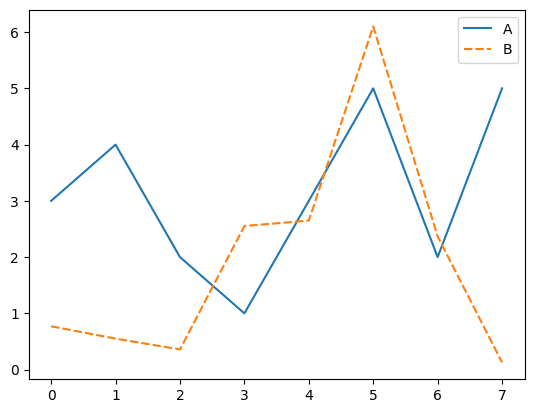

In [4]:
fig = sns.lineplot(data_simple).get_figure()
fig.savefig(r'umrr_utils/assets/test_plot.png')

In [5]:
path = r'test.xlsx'
writer = ExcelReporter(path) 
writer.add_dataframe(data_simple, 'Sheet', table_name='with_index', index=True, row_offset=4, col_offset=2)
writer.add_dataframe(data_simple, 'Sheet', table_name='without_index', index=False, row_offset=4, col_offset=7)
writer.add_dataframe(data_with_multiIndex, 'Sheet', table_name='with_multiIndex', index=True, row_offset=15, col_offset=2)
writer.add_image(r'umrr_utils/assets/test_plot.png', 'Sheet', row_offset=16.5, col_offset=7.5, scale=0.5)
writer.save()

![titles](umrr_utils/assets/example.png)

# Files utils

## pickle

In [21]:
from umrr_utils.files import f_loads

In [ ]:
f_loads.read_pickle('path')
f_loads.save_pickle(obj, 'path')

## load_module_from_path

In [ ]:
module = f_loads.load_module_from_path(module_path, module_name)

## text_ut

In [42]:
# Мини утилита для работы с файлами содержащими скрипты (хотя можно и любые другие текстовые).
from umrr_utils.files import text_ut

script = text_ut.load_text('example_data/test_sql.sql')
print(script)

# А теперь заменим значения в скрипте, если нужно.
script = text_ut.load_text('example_data/test_sql.sql',
                            replaces={'table_003': 'another_table'})
print('\nЗаменили таблицу')
print(script)

select * from db_001.table_003
limit 10

Заменили таблицу
select * from db_001.another_table
limit 10


# Other

## неточный string join
Например когда нужно заджоинить описания агрегатов из эксель, а имена столбцов не точные

In [1]:
from umrr_utils.other.custom_join import levenshtein_df_left_join

df_merged = levenshtein_df_left_join(df_left, df_right,
                                     # имена столбцов должны быть разные
                                     join_cols=['col_1', 'col_2'])

## KNOSIS SPM

Из проекта симулятора РБЛ. Много нюансов работы. Требуется чтобы в сэмпле были все необходимые столбцы и в правильных типах (как в справочнике). Справочник катофов например - knosis_dbo.v_dict_knosis_pd_rules

In [22]:
import umrr_utils.other.knosis_spm as knosis_spm

In [ ]:
# utility function to get catalogue for each row
# def return_calibr_coefs(row, spm_cat):
#     _idx = get_row_from_spm_cat(row, spm_cat, filt_cols=['client_category', 'extsystemcode'], 
#                          num_attr=6, text_attr=5, min_max_attr=(1,))
#     return row.append(spm_cat.loc[_idx, ['pd_a', 'pd_b', 'pd_k']])

# df_samp = df_samp.apply(lambda x: return_calibr_coefs(x, df_calibr_coef), axis=1)